# Module importieren

In [1]:
import mglearn
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

from pandas import DataFrame
from csv import reader
from sklearn import preprocessing, svm, metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.display import display
from mlxtend.plotting import plot_confusion_matrix


#Warnungen unterdrücken
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Daten einlesen und erste Analysen

In [2]:
datei='adult.csv'
data=pd.read_csv(datei)
datareduziert = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]
df= pd.DataFrame(datareduziert)
print("Folgende Schlüssel befinden sich im Datensatz:")
print(data.keys())
print()
print("Gesamte Anzahl der Datensätze: {}".format(data.shape[0]))

data.describe()

Folgende Schlüssel befinden sich im Datensatz:
Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

Gesamte Anzahl der Datensätze: 48842


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


# Analyse der Daten

## Heatmap

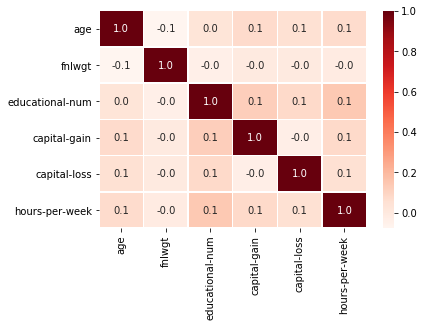

In [3]:
sns.heatmap(data.corr(),annot=True,fmt='.1f',linewidths=.5, cmap="Reds")  #We can use a simple seaborn method to draw the heatmaps


## Verteilung der Variablen
### Aufteilung der Geschlechter

Male      32650
Female    16192
Name: gender, dtype: int64


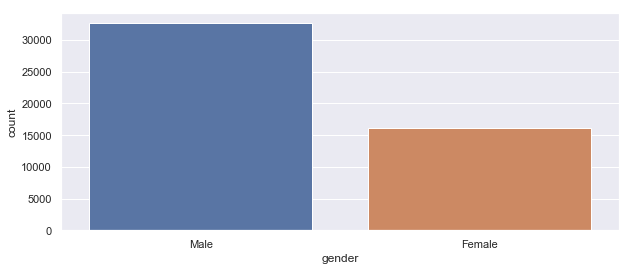

In [4]:
sns.set(style="darkgrid",rc={'figure.figsize':(10,4)})
#sns.load_dataset(data["gender"])
bar = sns.countplot(data=data, x="gender")
print(data.gender.value_counts())

### Einkommen nach Alter und Geschlecht

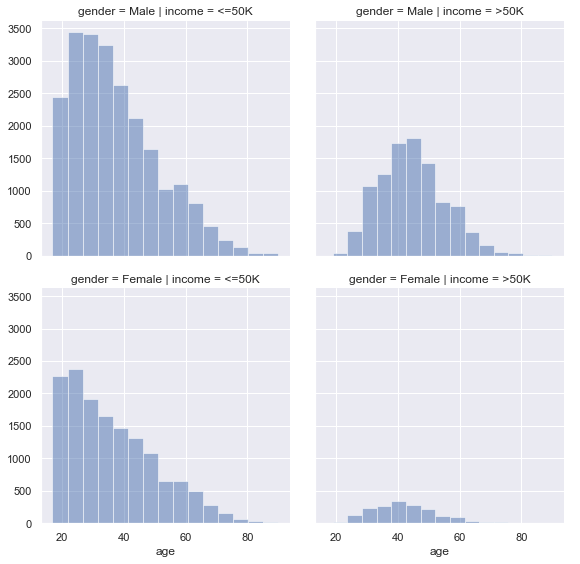

In [5]:
g = sns.FacetGrid(data, row='gender', col='income', height=4)
g.map(plt.hist, 'age', alpha=0.5, bins=15)
g.add_legend()
plt.show()

### Einkommen nach Berufsfeld

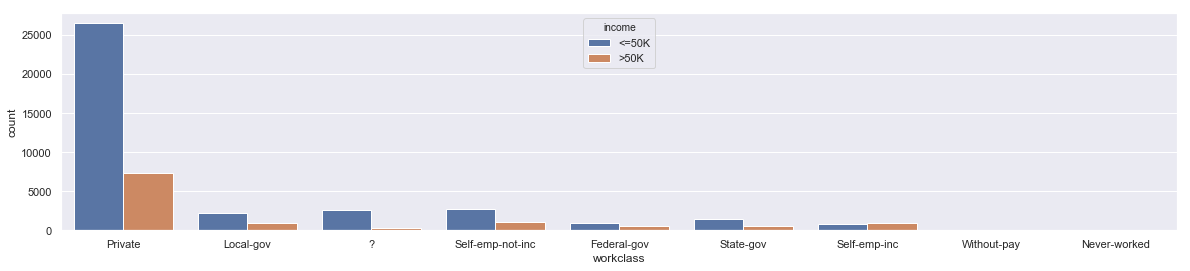

In [6]:
sns.set(style="darkgrid",rc={'figure.figsize':(20,4)})
bar = sns.countplot(data=data, x="workclass", hue="income")

In [7]:
df.head()

,age,workclass,education,gender,hours-per-week,occupation,income
0,25,Private,11th,Male,40,Machine-op-inspct,<=50K
1,38,Private,HS-grad,Male,50,Farming-fishing,<=50K
2,28,Local-gov,Assoc-acdm,Male,40,Protective-serv,>50K
3,44,Private,Some-college,Male,40,Machine-op-inspct,>50K
4,18,?,Some-college,Female,30,?,<=50K


age und hours-per-week sind kontinuierliche Merkmale

workclass, education, gender, occupation sind kategorische Merkmale (Kein Wertebereich, sondern festgelegte Liste von Werte) -> qualitative Eigenschaft

# One-Hot-Kodierung

### Spalten umwandeln

In [8]:
#print("Original features:\n", list(data.columns), "\n")
data_dummies = pd.get_dummies(data)
#print("Features after get_dummies:\n", list(data_dummies.columns))

### Neue Tabelle anzeigen

In [9]:
data_dummies.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_<=50K,income_>50K
0,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,28,336951,12,0,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,44,160323,10,7688,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,18,103497,10,0,0,30,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


### Neue Spalten umbenennen

In [10]:
data_dummies.rename(columns={'income_>50K': 'mehrals50K', 'income_<=50K': 'wenigerals50K'}, inplace=True)
#data_dummies.keys()

### Prüfung auf leere Zellen

In [11]:
if(data_dummies.isnull().values.any() == False):
    print("Keine Leeren Zellen im Datensatz vorhanden!")
else:
    print("Mindestens eine leere Zelle im Datensatz vorhanden!")

Keine Leeren Zellen im Datensatz vorhanden!


# Daten verarbeiten
### Variablen festlegen

In [12]:
#Remove labels
features = data_dummies.drop(['mehrals50K', 'wenigerals50K'], axis=1)
labels = data_dummies.mehrals50K
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.25, random_state=5)

#Ausgabe
print("Features")
print("Trainingsdaten: " + str(features_train.shape[0]))
print("Testdaten: " + str(features_test.shape[0]))
print()
print("Labels")
print("Trainingsdaten: " + str(labels_train.shape[0]))
print("Testdaten: " + str(labels_test.shape[0]))


Features
Trainingsdaten: 36631
Testdaten: 12211

Labels
Trainingsdaten: 36631
Testdaten: 12211


## Baseline erstellen

In [42]:
feature_list = list(features.columns)
#baseline_preds = features_test[:, feature_list.index('mehrals50K')]

# Random Forest

In [14]:
clf = RandomForestClassifier()
clf.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
predictions = clf.predict(features_test)

## Genauigkeit überprüfen 

Genauigkeit mit Prüfung der Testdaten: 84.78%



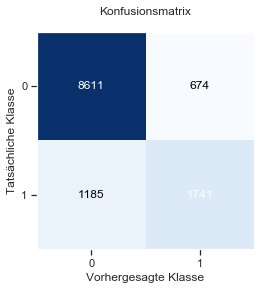

In [38]:
print ("Genauigkeit mit Prüfung der Testdaten:", str(round(accuracy_score(labels_test, predictions)*100,2)) + "%")
print()

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(labels_test, predictions))
ax.set(title="Konfusionsmatrix", ylabel='Tatsächliche Klasse', xlabel='Vorhergesagte Klasse')
plt.show()

[Quelle](http://dataaspirant.com/2017/06/26/random-forest-classifier-python-scikit-learn/)

# Tree

In [17]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(features_train, labels_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [18]:
y_pred = clf_gini.predict(features_test)

## Genauigkeit überprüfen

Genauigkeit mit Prüfung der Testdaten: 84.18%



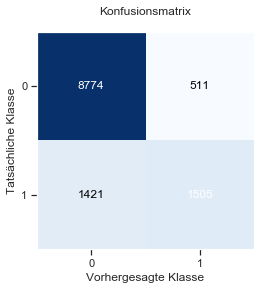

In [36]:
print ("Genauigkeit mit Prüfung der Testdaten:", str(round(accuracy_score(labels_test, y_pred)*100,2)) + "%")
print()

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(labels_test, y_pred))
ax.set(title="Konfusionsmatrix", ylabel='Tatsächliche Klasse', xlabel='Vorhergesagte Klasse')
plt.show()

[Quelle](http://dataaspirant.com/2017/02/01/decision-tree-algorithm-python-with-scikit-learn/)

# Gradient Boosting Classifier

In [20]:
#Create a svm Classifier
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 1, max_features=2, max_depth = 2, random_state = 0)
gb.fit(features_train, labels_train)

#Predict the response for test dataset
z_pred = gb.predict(features_test)

## Genauigkeit überprüfen

Genauigkeit mit Prüfung der Testdaten: 84.1%



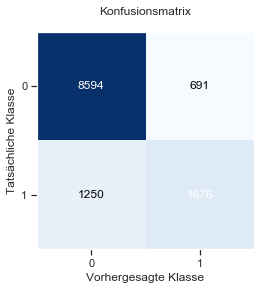

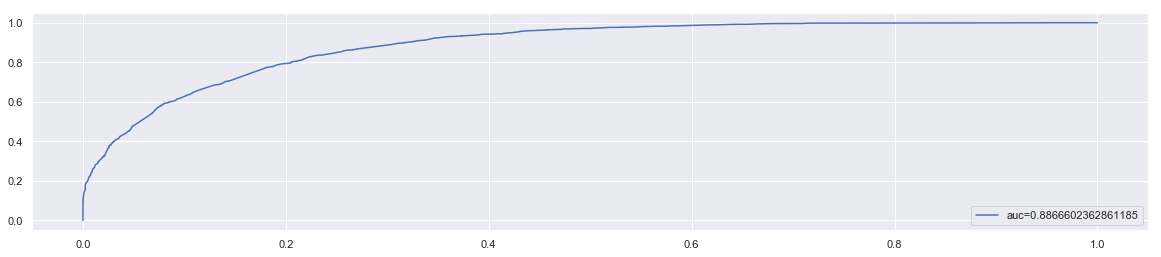

In [59]:
print ("Genauigkeit mit Prüfung der Testdaten:", str(round(accuracy_score(labels_test, z_pred)*100,2)) + "%")
print()

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(labels_test, z_pred))
ax.set(title="Konfusionsmatrix", ylabel='Tatsächliche Klasse', xlabel='Vorhergesagte Klasse')
plt.show()

test = gb.predict_proba(features_test)[::,1]

fpr, tpr, thresholds = metrics.roc_curve(labels_test, test)
auc = metrics.roc_auc_score(labels_test, test)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()


# Print AUC
#auc = np.trapz(fpr,tpr)
#print('AUC:', auc)

#plt.show()

# Crossvalidation

In [60]:
scores = cross_val_score(clf, features, labels, cv=5)
print(scores)
print("Durchschnitt: " + str(round((scores.mean()*100),2)) + "%")

[0.84409868 0.84256321 0.84684685 0.85002048 0.85094185]
Durchschnitt: 84.69%
